# LINEAR REGRESSION ASSUMPTIONS

[@sparshsah](https://github.com/sparshsah)

Acknowledgments: Prof Joe Blitzstein (Harvard), Prof Kevin Rader (Harvard), Prof Mark Glickman (Harvard), Prof Brant Abott (Queens Kingston) for lecture notes. Also Prof Andrius Buteikis (Vilnius) for his textbook, e.g. [here](http://web.vu.lt/mif/a.buteikis/wp-content/uploads/PE_Book/4-1-Multiple-Reg-Spec.html). I sometimes deviate from these sources where I feel there is space for interpretation; Any errors are my own.

In [1]:
from __future__ import annotations

from collections import OrderedDict
from typing import Final

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# https://github.com/sparshsah/foggy-statslib
import foggy_statslib.core as fc

# Brief rant about OLS


Linear models are extremely popular because they are very intuitive (you can draw out the equation on a single line) yet also very flexible (LM's with binary indicators, polynomial terms, and interaction terms can reasonably handle 80% of all real-world modeling needs).


Within this world, the ordinary-least-squares point-estimator is extremely popular because it is very easy to calculate ($(X'X)^{-1}X'y$)\*, yet also, under mild assumptions, has very nice properties (and if you're really in a pinch, you take some of those already-mild assumptions and relax them, and still get much of that same niceness _asymptotically_):


0. (P0) OLS is MLE
    * Don't take this one for granted in practice. For example, with Laplacian rather than Gaussian errors, LAD (not OLS) is MLE.


1. (P1) OLS is consistent
    * You can take this one for granted in practice. Pretty much, as long as your errors have a first moment---so Cauchy is out---the OLS estimate will converge to the ground truth.


2. (P2) OLS estimate is unbiased


3. (P3) OLS estimate's standard error is easy to calculate


4. (P4) OLS estimate is Normally-distributed


The first two are very reassuring and good for the blood pressure, but those last three are what pay the bills. They are what allow you to perform inference (alternative hypothesis vs null) by calculating a $t$-stat and comparing it to a looked-up value. (Or in practice, by comparing it to $1.96$, which makes your Student's test a Wald test, which is fine because none of the assumptions I'm going to list below is ever exactly true in reality, which is where the "asymptotically" part comes into play.)


\*Notice that, with centered data, $X'X$ is an estimated $(X)$-variance matrix, and $X'y$ is an estimated $(X,y)$-covariance vector. So this looks like the reciprocal of the variance of $X$ times the covariance of $X$ with $y$, for the general multivariate setting... which is exactly the formula for the slope coefficient in the simple univariate setting!

# Actual assumptions


Succinctly, you can say that the OLS apparatus assumes that
$$y_n \mid X_n \qquad\text{indep}\sim\qquad \mathcal{N}(\alpha + \beta'{X_n},\;\; \sigma).$$

Under this model, Gauss-Markov assures us that OLS will be not just MLE but the BULE (people say BLUE, I say BULE) (best---i.e. most efficient i.e. mininum-mean-squared-error---unbiased linear estimator).


Breaking it down, roughly in order of importance:


0. **Linearity of data-generating process**: $E(Y_n | X_n)$ can be expressed as $\alpha + \beta'{X_n}$ for some ground-truth $\alpha$, $\beta$.


1. **Zero-mean errors**: $E(\varepsilon_n | X) = E(\varepsilon_n | X_n) = E(\varepsilon_n) = 0$.
    * In some cases, this property can be recovered by a panel structure, wherein observations from different entities (*cough* platforms) and timesteps (*cough* vintages) can have independent intercepts (which, cleverly, is simply implemented with binary indicators and interactions!). But if not, you're kind of shot. Your bet is to find some augmenting regressor such that, _conditional on that regressor_, you have zero-mean errors.


2. **Independent errors**: $\varepsilon_n \perp \varepsilon_m$ if $n \neq m$.
    * Even if this is violated, your estimate will still remain consistent and unbiased.
    * However, you will have an ULE (unbiased linear estimator) not a BULE. You can recover the bestness with a Feasible Generalized Least Squares approach like Cochrane–Orcutt. With that said, I have never done this in my life, because...
    * ... Even if you don't use FGLS, you can try to remediate the inconsistency induced in your standard-error estimation with a HAC SE estimator like Newey-West. (A beauty of Newey-West is that it produces consistent SE estimates _even if you don't know whether errors are positively- or negatively-correlated across observations_! You just have to have some idea of a `max_lag` beyond which they are uncorrelated.) This is most common in practice: Simply accept the consistent and unbiased OLS point estimates, and correct the SE estimates with Newey-West for inference.


3. **Homoskedastic errors**: $\text{Std}(\varepsilon_n) = \sigma = \text{Std}(\varepsilon_m)$.
    * The point estimate remains unbiased even if this is violated, and although the usual SE estimate is inconsistent, that is fixed pretty easily with Huber-White standard error estimator. And if you're not happy with a LUE (linear unbiased estimator), then using (feasible) weighted least squares will get you back to BLUE (best---i.e. most efficient i.e. lowest-MSE---linear unbiased estimator).


23\. The variance-covariance matrix of the errors is just a scalar times the identity matrix, $\text{Var}(\mathbf{\varepsilon}) = \sigma{I}$. This is basically an encapsulation of (A2) and (A3).


4. **Gaussian errors**.
    * As I said above, this one is cute because it makes OLS the MLE, and convenient because it lets us use the exact small-sample Student's $t$ test. But even if you have Laplacian errors (in which case the LAD is the MLE), OLS gives a good estimate, and its problems pretty much vanish with large sample size. And again, you pretty much always need a large sample size (the "rule of thumb" in stats is like 30+ for things like the Central Limit Theorem to kick in) because you're never going to have all these assumptions hold exactly in practice, so you're going to need to pass from the finite-sample Student's test to the asymptotic Wald test, which is essentially the same procedure but just assumes that the $t$-stat (really, its square) has converged to standard Normality (really, to standard Chi-squareness).


1234\. The error vector is multivariate Normal with zero mean and variance-covariance matrix that is just a constant times the identity. This is basically an encapsulation of (A1) - (A4).

## Proofs of properties

Really, Gauss-Markov proves them all. But I want to prove one important one here myself for a simple case.

### (P2) Unbiased

#### BLUF

Exactly as I promise above, when you run a linear regression, as long as your model is correctly-specified and your errors have zero mean, your OLS estimate will be unbiased for $\beta$. You don't even need independent errors!

#### Setting

Okay, very very simple univariate setting. You have $N$ observations $(Y_n,\, X_n)$. They are stacked into a vectors $Y$, $X$. (Note: Usually we use the uppercase letters to denote the random variables, but here I'm using the uppercase letters to denote the observed data vectors. I need the lowercase letters for something else.) We also have centered versions $y$ and $x$ where $y_n := Y_n - \bar{Y}$ and similarly for $x_n$. Finally, let me define $k_n := \frac{x_n}{\sum x_n^2}$.

Below, take every $\sum$ to mean $\sum_{n=1}^N$.

#### Lemma 0: $\sum x_n = 0$

Pf: $\sum x_n := \sum (X_n - \bar{X}) = \sum X_n - \sum \bar{X} = \sum X_n - n\bar{X} = \sum X_n - \sum X_n = 0$.

#### Lemma 1: $\sum k_n = 0$

Pf: $\sum k_n := \sum (x_n / \sum x_n^2) = \sum x_n / \sum x_n^2$, whence by (L0) we have QED.

#### Lemma 2: $\sum k_n^2 = \frac{1}{\sum x_n^2}$

Pf: $\sum k_n^2 = \sum \left(\frac{x_n}{\sum x_n^2}\right)^2 = \sum \frac{x_n^2}{(\sum x_n^2)^2} = \frac{\sum x_n^2}{(\sum x_n^2)^2} = \frac{1}{\sum x_n^2}$.

#### Lemma 3: $\sum k_n x_n = \sum k_n X_n$

Pf: $\sum k_n x_n =: \sum k_n (X_n - \bar{X}) = \sum k_n X_n - \sum k_n \bar{X} = \sum k_n X_n - \bar{X} \sum k_n$ whence by (L1) we have QED.

#### Lemma 4: $\sum k_n x_n = 1$

Pf: $\sum k_n x_n = \sum \left(\frac{x_n}{\sum x_n^2}\right) x_n = \frac{1}{\sum x_n^2} \sum (x_n) x_n = \frac{1}{\sum x_n^2} \sum x_n^2 = 1$.

#### Lemma 5: $\sum k_n X_n = 1$

Pf: Follows from (L3) and (L4).

#### Main proof

I will express the OLS slope point estimate as

$$\hat{\beta} = \frac{\sum y_n x_n}{\sum x_n^2}$$

$$ := \frac{\sum (Y_n - \bar{Y}) x_n}{\sum x_n^2}$$

$$ = \frac{\sum Y_n x_n}{\sum x_n^2}  -  \frac{\sum \bar{Y} x_n}{\sum x_n^2}$$

$$ = \frac{\sum Y_n x_n}{\sum x_n^2}  -  \frac{\bar{Y} \sum x_n}{\sum x_n^2}$$

where by (L0) we have

$$ = \frac{\sum Y_n x_n}{\sum x_n^2}$$

$$ =: \sum Y_n k_n.$$

We can substitute based on the ground-truth model (it's OK that we don't know $\alpha$ or $\beta$ or $\varepsilon_n$ -- they're going to cancel out in a moment):

$$ = \sum (\alpha + \beta X_n + \varepsilon_n) k_n $$

$$ = \sum \alpha k_n + \sum \beta X_n k_n + \sum \varepsilon_n k_n $$

$$ = \alpha \sum k_n  +  \beta \sum X_n k_n  +  \sum \varepsilon_n k_n $$

Whence by (L1) and (L5) we get

$$ = \beta + \sum \varepsilon_n k_n .$$

Now we can take the expectation given $X$,

$$ \boxed{ E(\hat{\beta} \mid X) } = E( \beta + \sum \varepsilon_n k_n \mid X ) $$

which by linearity,

$$ = E( \beta \mid X ) + E( \sum \varepsilon_n k_n \mid X ) $$

whence, observing that the $k_n$'s are deterministic functions of the $X_n$'s, we get again by linearity,

$$ = E( \beta \mid X ) + \sum E(\varepsilon_n \mid X) k_n $$

whence by (A1) (Zero-mean errors),

$$ = E( \beta \mid X ) + \sum 0 k_n $$

$$ = E( \beta \mid X ) $$

and here's the crux: $\beta$ is unknown, but it's a constant (in the frequentist paradigm anyhow -- if you're a Bayesian, then OLS is not the tool for you), and therefore we have

$$ = \boxed{ \beta } .$$

So, we have shown that $E(\hat{\beta} \mid X) = \beta$, the expected value of the estimated beta is indeed the ground-truth beta, _quod erat demonstrandum_.

# Redundant assumptions (true but already covered by the above)

## No omitted variables

Suppose there is another regressor $Z_n$. We can write $Y_n = \alpha + \beta X_n + \gamma Z_n + \epsilon_n$, where we have $\varepsilon_n = \gamma Z_n + \epsilon_n$.

Now, if $\text{Corr}(X_n,\,Z_n) = 0$ or $\gamma = 0$, then there is no problem.

But if the correlation between $X_n$ (which you can observe) and $Z_n$ (which you can't observe but still exists) is nonzero and $\gamma \neq 0$? You will get OVB on $\hat{\beta}$, with direction

$$\text{sgn}(E(\hat{\beta} - \beta)) \qquad=\qquad \text{sgn}(\text{Cov}(X_n,\,Z_n)) \cdot \text{sgn}(\gamma).$$

Seems like a problem, right? Didn't I promise that OLS was unbiased?

Well yes... but we already knew this would be a problem! Hand-wavily: $X$ is predictive of $Z$, and $Z$ appears uncancelled in the error term $\varepsilon$, which means that $X$ is predictive of $\varepsilon$, and you have violated (A1)!

## Stationarity

This is classic. You will hear this all the time: "Regressing a driftless random walk $Y$ on an independent driftless random walk $X$ will lead to spurious coefficients. Therefore, you must regress returns on returns, not prices on prices."

Well, yes, but... We already knew that! In this setting, ex-ante, $E(Y_t) = 0$. Indeed, $E(Y_t | X_t) = 0$, and even $E(Y_t \mid X) = 0$. But, $Y_t$ is just $Y_{t-1}$ plus some white noise. And $Y_{t-1}$ includes the previous error term $\varepsilon_{t-1}$.

You can intuit the problem here: This doesn't cancel out. $\varepsilon_{t-1}$ is going to be highly-predictive of $\varepsilon_t$. We're going to see $E(Y_t | X) = 0$, but $E(Y_t | X,\, Y_{t-1}) = Y_{t-1}$. You have violated (A2)!

# Extraneous assumptions (not true)

## Non-multi-collinear $X$

Why do people hate collinearity in $X$? Because it blows out standard errors, and makes your point estimates imprecise (although still consistent and unbiased!). In fact, in the extreme case of perfect multicollinearity, there will be no unique MLE. (Imagine a case where you regress on two copies of some column `X[:, k]`: As long as the sum of the two columns' coefficients stays constant, the loss will be the same.)

BUT... It doesn't matter!

* In the first case, you should expect to see small $t$-stats which will let you know what's going on. (And if you don't see small $t$-stats, that means that your observed $X$ dataset didn't have multicollinearity despite the fact that there is ground-truth multicollinearity, in which case you couldn't have caught the multicollinearity anyway. And if you DID know that there was ground-truth multicollineearity in $X$ before you even observed the data, then what the hell are you doing estimating SE's? You obviously know the covariance matrix $\Sigma$ of $X$, use that to calculate the ground-truth SE's exactly!)

* In the second case, your $X'X$ matrix will be singular and Python will complain when you try to invert it. (Okay, okay, fine, you can say that "no perfect multicollinearity" is an assumption if you want OLS to give you a unique MLE... But for me, remembering and checking for an extra assumption is a waste of time given that in the rare cases where it's a problem, my code will either warn me with small $t$-stats, or in the extreme case just straight-up throw an error.)

## Exploitable variation in observed $X$

Yes, but if one of your columns of $X$'s is the same for every observation (i.e. you never observed an individual from outside that class), then that column will be perfectly collinear with the intercept (the column of ones), which we already dealt with above.

## Balanced classes in observed dataset

Gauss-Markov assumes nothing about class balance. Indeed, my proof above assumed nothing above class balance. However, it _is_ true that, conditional on how much data you observe, if you can achieve class balance within that dataset, you can reduce standard error. Recall that $MSE = Bias^2 + SE^2$ (this is the crux of the bias-variance tradeoff!), so that even if you have two unbiased estimators, the one with smaller standard errors will have smaller mean squared error.

So if you're a PI, and you're running clinical trials on some drug, and you eagerly assign 90% of your subjects to the treatment group (leaving only 10% for the control), you could actually get _worse_ inferential efficiency than if you had just split them evenly. Hypothesis testing is vital to FDA approval, so this is very important.

Now realize this doesn't mean that if you already have a study with 10 control participants and 90 treated participants after the fact, that you should randomly drop 80 of the latter; And it certainly doesn't mean that you need to start haphazardly attempting to bootstrap magical new observations\* either. It just means that if you're setting out to do a study, and your department's given you funding for 100 subjects, you ought to consider splitting them evenly.

Unfortunately, it would take me longer than 10 minutes to prove this statement analytically; But fortunately, it will take me only 10 minutes to suggest it with simulated data below.


\*Prof Blitzstein happened to give his lecture on bootstrapping on May 24, the birthday of Brad Efron, the inventor of bootstrapping. Prof Blitzstein lamented that he had wanted to bring cake to class to celebrate the coincidence, but he wouldn't have been able to carry enough to serve all of Science Center C. But then he pointed out to us that if he had kept his wits about him, he would have realized that he could just bring one cake to class, and bootstrap enough slices to serve everyone!

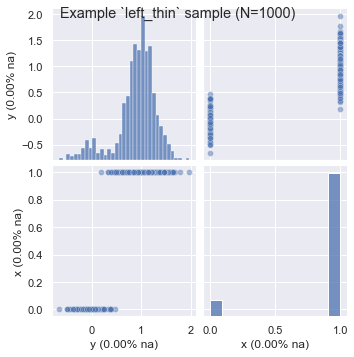

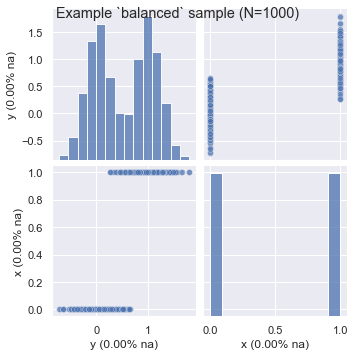

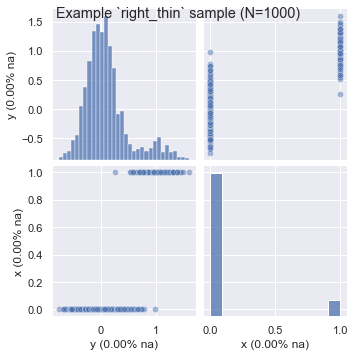

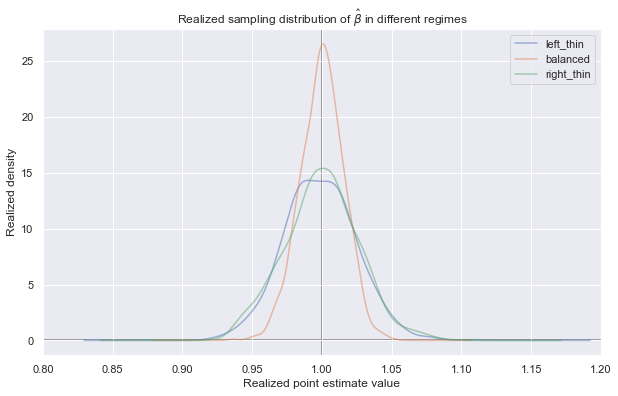

DESCRIPTION:
         left_thin     balanced   right_thin
count  1000.000000  1000.000000  1000.000000
mean      0.998702     0.999950     0.999537
std       0.025956     0.015637     0.026619
min       0.920163     0.936167     0.923896
25%       0.981406     0.989458     0.982266
50%       0.998498     1.000409     0.999665
75%       1.015842     1.010087     1.016930
max       1.101514     1.049977     1.089025


In [10]:
N: Final[int] = 1_000
T: Final[int] = 1_000
REGIMES: Final = OrderedDict(
    [
        ("left_thin", {"n_0": N//10, "n_1": 9*N//10}),
        ("balanced", {"n_0": N//2, "n_1": N//2}),
        ("right_thin", {"n_0": 9*N//10, "n_1": N//10}),
    ]
)


def _draw_samples_of_one_class(x: int = 0, n: int = N) -> pd.DataFrame: 
    """Model where E[y | x] = x."""
    samples = pd.DataFrame({"y": x, "x": x}, index=range(n))
    noise = np.random.normal(size=n, scale=0.25)
    samples.loc[:, "y"] = samples["y"] + noise
    return samples


def _draw_samples_of_both_classes(n_0: int = N//2, n_1: int = N//2) -> pd.DataFrame:
    samples_0 = _draw_samples_of_one_class(x=0, n=n_0)
    samples_1 = _draw_samples_of_one_class(x=1, n=n_1)
    samples = pd.concat([samples_0, samples_1], ignore_index=True)
    return samples


def _calc_est_beta_from_data(samples: pd.DataFrame) -> float:
    lm = LinearRegression().fit(y=samples["y"], X=samples["x"].to_frame())
    b = lm.coef_[0]
    return b


def _sim_est_beta_for_one_trial(n_0: int = N//2, n_1: int = N//2)-> float:
    samples = _draw_samples_of_both_classes(n_0=n_0, n_1=n_1)
    b = _calc_est_beta_from_data(samples=samples)
    return b


def _sim_est_betas_for_many_trials(n_0: int = N//2, n_1: int = N//2, trials: int = T) -> pd.Series:
    bs = pd.Series([_sim_est_beta_for_one_trial(n_0=n_0, n_1=n_1) for _ in range(trials)])
    return bs


def _sim_est_betas_for_many_trials_across_regimes() -> pd.DataFrame:
    bs = pd.DataFrame(
        OrderedDict(
            [
                (
                    # key (regime)
                    regime,
                    # value (est'd beta's)
                    _sim_est_betas_for_many_trials(
                        n_0=ns["n_0"],
                        n_1=ns["n_1"],
                    )
                )
                for (regime, ns) in REGIMES.items()
            ]
        )
    )
    return bs


def show() -> None:
    np.random.seed(42)
    example_samples = OrderedDict(
        [
            (
                # key (regime)
                regime,
                # value (est'd beta's)
                _draw_samples_of_both_classes(
                    n_0=ns["n_0"],
                    n_1=ns["n_1"],
                )
            )
            for (regime, ns) in REGIMES.items()
        ]
    )
    for (regime, sample) in example_samples.items():
        fc.plot_eda(sample, title=f"Example `{regime}` sample (N={sample.shape[0]})")
    bs = _sim_est_betas_for_many_trials_across_regimes()
    fc.plot(
        bs,
        kind="density", alpha=0.50,
        axvline_locs=(1,),
        xlim_left=0.80, xlim_right=1.20,
        ylabel="Realized density",
        xlabel="Realized point estimate value",
        title=r"Realized sampling distribution of $\hat{\beta}$ in different regimes",
        figsize=(10, 6),
    )
    print(f"DESCRIPTION:\n{bs.describe()}")


show()

## Dropping outliers

This gets a mention only because high-school stats classes routinely advise that you should check for and drop outliers. Some of them even take the extra step of making this rigorous using Cook's distance or the like.

The argument is either:
* That the outlier is a red herring, drawn from a different distribution, that distracts from the story the data so desperately wants to tell you;

Or:
* That even if the outlier is drawn from the same distribution, the bad luck of how different it is from the rest of the data forces you to drop it (because---and this is part is actually correct---observations with large Cook's distance have outsize influence on the estimated coefficients thanks to the deliberate fact that OLS minimizes _squared_ deviations).

In the first case, I have softened and come around a bit. I've been convinced that in certain instances, you might care about being correct during certain regimes (like normal periods) and not during others (like high-VIX periods). In those instances, if you can reliably identify which observations are drawn from one of the "I don't care" regimes, you might want to drop them.

But my overall philosophy on this stays the same: The data is the data, the model is the model. The data can't be wrong, it's the data. The model, on the other hand, _can_ be misspecified --  It's just something you made up. More helpfully, you should consider something like FWLS (feasible weighted least squares), which will naturally tend to downweight the "came from a crazy-noisy regime" observations. FWLS is a way of dealing with heteroskedastic data-generating processes that affects the point estimates, not just their standard errors.